# Optical Flow
## Sparse Optical Flow

As always start by importing the relevant packages.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils
import glob
import os
import tensorflow as tf
from tensorflow import keras
import scipy
import scipy.io
from keras.applications.vgg19 import decode_predictions
import math
filepath = "Data/Stereo_conveyor_without_occlusions_rectified/"

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.5
fontColor              = (255,255,255)
lineType               = 1

Using TensorFlow backend.


Load the images "OF1.jpg" and "OF2.jpg" and change them to grayscale.

In [2]:
def image (img_left,img_right, img_left_plus_1, img_right_plus_1):
    img1 = cv2.imread(filepath + 'left/' + str(img_left))
    img1right = cv2.imread(filepath + 'right/' + str(img_right))
    img2 = cv2.imread(filepath + 'left/' + str(img_left_plus_1))
    img2right = cv2.imread(filepath + 'right/' + str(img_right_plus_1))

    b,g,r = cv2.split(img1) # Changing the order from bgr to rgb so that matplotlib can show it
    img1 = cv2.merge([r,g,b])
    b,g,r = cv2.split(img1right) # Changing the order from bgr to rgb so that matplotlib can show it
    img1right = cv2.merge([r,g,b])
    b,g,r = cv2.split(img2) # Changing the order from bgr to rgb so that matplotlib can show it
    img2 = cv2.merge([r,g,b])
    b,g,r = cv2.split(img2right) # Changing the order from bgr to rgb so that matplotlib can show it
    img2right = cv2.merge([r,g,b])

    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray1right = cv2.cvtColor(img1right, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    gray2right = cv2.cvtColor(img1right, cv2.COLOR_RGB2GRAY)
    return gray1, gray2, gray1right, gray2right, img2, img2right

    
    

In [3]:
def img_list(str):
    glb = glob.glob(str)
    lst = sorted(glb)
    return lst

Generate a list

In [4]:
left_imglist = img_list(filepath + 'left/*.png')
filename_left=[]
for i in left_imglist:
    filename_left.append((os.path.basename(i)))
right_imglist = img_list(filepath + 'right/*.png')
filename_right=[]
for i in right_imglist:
    filename_right.append((os.path.basename(i)))

Optical flow + dialation and erosion funtion

In [5]:
def filtering(gray1, gray2, img2):
    #gray1, gray2, img2= image(filename_left[i],filename_left[i+1])
    
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.5, 0)
    mag, angle =cv2.cartToPolar(flow[..., 0], flow[...,1])

    mask=np.zeros_like(img2)

    mask[...,1]=255
    mask[...,0]= angle*180/np.pi/2
    mask[...,2]=cv2.normalize(mag,None,0,255, cv2.NORM_MINMAX)

    rgb= cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    
    kernel=np.ones((5,5))
    ero=cv2.erode(rgb,kernel, iterations=4)
    plt.imshow(ero)
    dia=cv2.dilate(ero,kernel,iterations=7)
    ero2=cv2.erode(dia,kernel, iterations=3)
    
    #plt.imshow(ero2)
    final=img2+ero2
    
    dia3=cv2.dilate(ero2,kernel,iterations=20)
    ero3=cv2.erode(dia3,kernel,iterations=22)
    
    
    gray=cv2.cvtColor(ero3, cv2.COLOR_RGB2GRAY)
    threshold = 10
    threshold_value =255

    thresh = cv2.threshold(gray, threshold, threshold_value, cv2.THRESH_BINARY)[1]
    #plt.imshow(thresh, cmap='gray')
    return thresh

The biggest blob is the box

In [6]:
def biggest(thresh):
    
    
    kernel=np.ones((5,5))
    ero=cv2.erode(thresh,kernel, iterations=5)
    plt.imshow(ero)
    dia=cv2.dilate(ero,kernel,iterations=5)
    
    
    
    cnts = cv2.findContours(dia.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    #print(cnts)
    #text = "I found {} objects!".format(len(cnts))


    largest_area=0
    current_area=0
    index=-1

    for c in range(len(cnts)):
        current_area=cv2.contourArea(cnts[c])
        if current_area>largest_area:
            largest_area=current_area
            index=c
        
    return index, cnts

In [7]:
def disparitymap(img_left,img_right):
    
    stereo = cv2.StereoBM_create(numDisparities=96, blockSize=31)
    disparity = stereo.compute((img_left),(img_right))
    return disparity

In [8]:
def find_z (dis,boundRect):
    newimg = np.zeros_like(dis[:,:])
    newmask = np.zeros_like(dis[:,:])
    cv2.rectangle(newmask, (int(boundRect[0]), int(boundRect[1])), \
      (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (255), -1)
    newmask = newmask  == 255

    newimg[newmask] = dis[newmask]
    distance_vector = dis[newmask]
    plt.imshow(newimg,'gray')
    distance_vector_mask = distance_vector > 100
    distance_vector = distance_vector[distance_vector_mask]
    z_coordinate = np.median(distance_vector)
    return z_coordinate

In [9]:
def update(x, P, Z, H, R,I):
    # Insert update function
    Y = Z-H@x
    S = H@P@np.transpose(H) + R
    K = P@np.transpose(H)@np.linalg.pinv(S)
    x = x+K@Y
    P = (I-K@H)@P
    
    return [x,P]
    
def predict(x, P, F, u):
    ### insert predict function
    x = F@x + u
    P = F@P@np.transpose(F)
    
    return [x,P]

In [10]:
def kalman(cx,cy,cz,x,y,z,P_x,P_y,P_z, new_object,detected):
    if new_object==0:
        colour=(0,0,255)
        return x,y,z,P_x,P_y,P_z, colour
    elif new_object==1:
        # The initial uncertainty. We start with some very large values
        P_x = np.array([[1000, 0],
                        [0, 1000]])
        P_y = np.array([[1000, 0],
                        [0, 1000]])
        P_z = np.array([[1000, 0],
                        [0, 1000]])
        # The initial state. The robot starts in position 0 with the velocity 0.
        x = np.array([[cx], # Position along the x-axis
                      [0]])# Velocity along the x-axis
        y = np.array([[cy], # Velocity along the y-axis
                      [0]])# Velocity along the y-axis
        z = np.array([[cz], # Velocity along the y-axis
                      [0]])# Velocity along the y-axis
        # The initial uncertainty. We start with some very large values.
        print("initialasing")
        

    # The external motion. Set to 0 here.
    u = np.array([[0],
                  [0]])
    # The transition matrix. 
    F = np.array([[1, 1],
                  [0, 1]])
    # The observation matrix. We only get the position as measurement.
    H = np.array([[1, 0]])
    # The measurement uncertainty
    R = 1
    # The identity matrix. Simply a matrix with 1 in the diagonal and 0 elsewhere.
    I = np.array([[1, 0],
                  [0, 1]])
    # You can use the following measurements or come up with your own.
    
### Loop through the measurements ###
#for i in range(0,len(measurements_x)):
#0-never seen anything
#1-new object
#2- has seen an object before

    if detected==True:    
        [x,P_x] = update(x, P_x, cx, H, R,I)
        [y,P_y] = update(y, P_y, cy, H, R,I)
        [z,P_z] = update(z, P_z, cz, H, R,I)
        print("updating")
        colour=(0,255,0)
    else:
        colour=(0,0,255)
        
    [x,P_x] = predict(x, P_x, F, u)
    [y,P_y] = predict(y, P_y, F, u)
    [z,P_z] = predict(z, P_z, F, u)
    #print("predicting")


    return x,y,z,P_x,P_y,P_z,colour
    

In [11]:
def real(cnts, memory_area, new_object, index, status,passed, new_index,medium):

    if (index != -1):
        
        cnt = cnts[index]
        area = cv2.contourArea(cnt)#find area of contour of interest
        
        if area>1200 and area<40000:
        #make sure the area is not too small->noise or too big->hand
        
            x=-1
            memory_area[0].append(area)# save the area
            a=area
            
            if cnt[0][0][0]>450:#where is the object found
                memory_area[1].append(0)#is beginning its path
                b=0
            else:
                memory_area[1].append(1)#is ending its path
                b=1
            
            mem=0
            direction=0
            
            if (len(memory_area[0])-new_index)>10:
                #once we have enough areas of the same object we calculate what's the expected area of the object
                if passed<10:#make sure that the occlusion has not happened and our area data is close to each other
                    while x>-10:
                        mem=(mem+memory_area[0][x])/2
                        x=x-1
                else:
                    mem=area
                x=-1
                
                while x>-4:
                    direction=direction+memory_area[1][x]#sum of all directions 
                    x=x-1
                #find status of system:
                    #0- never seen anything (system waits for an object)
                    #0- object starting trajectory
                    #1- object ending trajectory
                #new_object variable:
                    #0- never seen anything (system waits for an object)
                    #1- new object (only first iteration)
                    #2- has seen an object
                    
                if direction==0:#the beginning is always 0
                    if status==0: #here please or status==2:#there is a new object passed from not seeing
                        new_object=1 
                        status=1
                        print("new object detected")
                        
                        new_index=len(memory_area[0])-1 #save index of new object
                        medium=0 #the minimum value of the objects area needs to be calculated
                        
                    else:#other
                        new_object=2 #not first iteration
                        
                        if medium==0 and (len(memory_area[0])-new_index)==35:
                            #when there's enough data calculate the minimum area. 
                            #all other areas should be bigger. this applies to this particular object
                            medium=mem
                            
                elif direction>2:#has it passed the threshold and it's ending the path
                    new_object=2
                    status=0
                else:
                    new_object=2
            else:
                mem=area#not enough data to create a memory
                
            detected=True
            
            if abs(mem-area)>5000:#if difference is too big we have noise
                area=mem #set area to the previous medium
                detected=False #this will not be used
                print("area to different")
                passed=passed+1 #one data not used
            #return area, cnt, status, new_object
            else:
                passed=0
                #initialasing passed
            if area<medium or cnt[0][0][0]>800 :
                print("the area is smalled than our minimum")
                detected=False
                passed=passed+1
        else:
            print("area out of bounds", area)
            #area is either too small or too big
            area=False
            detected=False
            passed=passed+1
    else:
        #not found anything
        area=False
        cnt=[[[False]]]
        detected=False
        passed=passed+1
    
    return area, status, new_object, cnt,detected,passed, new_index, medium

In [43]:
def show(area, img2, cnts, new_object,cx_old,cy_old,cz,index, memory_cnt):

    output = img2.copy()
    roi = []
    roilarge = []
    if (index != -1):
        cnt = cnts[index]
        area1 = cv2.contourArea(cnt)
        dif=area-area1
        if dif==0:
            contours_poly = cv2.approxPolyDP(cnt, 3, True)
            boundRect = cv2.boundingRect(contours_poly)
            x, y, w, h = boundRect
            roi = img2[y:y+h, x:x+w]
            if(w*h >2500):
                if(w+h < 150):
                    extrah = 40
                    extraw = 50
                    roilarge = img2[y-extrah:y+h+extrah, x-extraw:x+w+extraw]
                elif(w+h < 200):
                    extrah = 20
                    extraw = 40
                    roilarge = img2[y-extrah:y+h+extrah, x-extraw:x+w+extraw]
                elif(w+h < 250):
                    extrah = 30
                    extraw = 30
                    roilarge = img2[y-extrah:y+h+extrah, x-extraw:x+w+extraw]
                elif(w+h < 300):
                    extrah = 20
                    extraw = 20
                    roilarge = img2[y-extrah:y+h+extrah, x-extraw:x+w+extraw]
                elif(w+h > 300):
                    extrah = 10
                    extraw = 10
                    roilarge = img2[y-extrah:y+h+extrah, x-extraw:x+w+extraw]
            
            cv2.drawContours(output, cnt, -1, (0, 255, 0), 3)
            cv2.rectangle(output, (int(boundRect[0]), int(boundRect[1])), \
              (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (0, 255, 255), 2)
            #keep memory of bb
            memory_cnt[0].append(int(boundRect[0]))
            memory_cnt[1].append(int(boundRect[1]))
            memory_cnt[2].append(int(boundRect[0]+boundRect[2]))
            memory_cnt[3].append(int(boundRect[1]+boundRect[3]))
            M = cv2.moments(cnt)
            #print( M )
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            difference=math.sqrt(((cx-cx_old)**2)+((cy-cy_old)**2))
            if abs(difference)>1000:
                cx=cx_old
                cy=cy_old
                print("difference too high")
            #print(cx,cy)
            center_coordinates=(cx,cy)
            circle=cv2.circle(output.copy(),center_coordinates,10,(255,0,0),cv2.FILLED)#circle --> center and radius also filled colour
            #circle=output.copy()
            cz=find_z(dis,boundRect)
            detected=True
            #print(cx,cy,cz)
        else:
            
            detected=False
            area=False
            cx=cx_old
            cy=cy_old
            center_coordinates=(cx,cy)
            cv2.rectangle(output, (memory_cnt[0][-1], memory_cnt[1][-1]), \
              (memory_cnt[2][-1], memory_cnt[3][-1]), (0, 255, 255), 2)
            circle=cv2.circle(output.copy(),center_coordinates,10,(255,0,0),cv2.FILLED)
            
    else:
        circle=output.copy()
        detected=False
        area=False
        cx=cx_old
        cy=cy_old
    return cx,cy,cz,circle,new_object,detected,area,roi, roilarge

In [13]:
def triangulation(cx,cx_right,cy,cy_right,cz,cz_right):
    cx_real=cx
    cy_real=cy
    cz_real=cz
    return cx_real, cy_real, cz_real

Finding the center and saving the image

In [18]:
def build_model(a):
    model = tf.keras.applications.VGG19(
            include_top=True,
            weights="imagenet",
            input_tensor=None,
            input_shape=None,
            pooling=None,
            classes=1000,
        )
    return model

In [77]:
def classifyImage(image,model,y):
    #Input image, output class, confidence
    
    # resize image to 244 x 244 which is input for VGG19
    resize_number = min(224/image.shape[1],224/image.shape[0])
    resized_image = cv2.resize(image, (0,0), fx=resize_number, fy=resize_number) 
    pad_image = cv2.copyMakeBorder( resized_image,int(math.ceil((224-resized_image.shape[0])/2)), 
                                   int(math.floor((224-resized_image.shape[0])/2)), int(math.ceil((224-resized_image.shape[1])/2)), 
                                   int(math.floor((224-resized_image.shape[1])/2)), cv2.BORDER_REPLICATE)
    #plt.imshow(zeropad_image)
    
    
    '''
    # convert the probabilities to class labels
    label = decode_predictions(yhat)
    # retrieve the most likely result, e.g. highest probability
    label = label[0][0]
    # print the classification
    print(decode_predictions(yhat))
    print('%s (%.2f%%)' % (label[1], label[2]*100))'''
    
    #make the prediction on rezised image
    yhat = model.predict(np.array([pad_image]))
    
    #print(yhat[0][0])
    # decode the predictions, get the first 250
    out = decode_predictions(yhat, top = 1000)
    out1 = decode_predictions(yhat, top = 25)
    #print(yhat)
    #print("\n")
    if(len(y) == 0):
        yhat
        
    else:
        yhat = y + yhat
    
    
    #itemlist_cup = ["n07930864","n15075141","n04254120","n03887697","n04116512","n03314780","n03916031",
    #                "n03131574","n03944341","n04009552"]
    #itemname_cup = ["cup","toilet_tissue","soap_dispenser","paper_towel","rubber_eraser","face_powder","perfume"
    #               ,"crib","pinwheel","projector"]
    #itemlist_box = ["n02971356","n04372370","n04040759","n02747177"]
    #itemname_box = ["carton","switch","radiator","ashcan"]
    #itemlist_book = ["n02840245","n03291819","n03871628","n07248320","n03492542","n03777754","n03179701",
    #                "n04380533","n03201208","n03787032"]
    #itemname_book = ["binder",    "envelope", "packet", "book_jacket", "hard_disc", "modem","desk"
    #                ,"table_lamp","dining_table","mortarboard"]
    
    itemlist_cup = ["n07930864","n15075141","n04040759"]
    itemname_cup = ["cup","toilet_tissue","radiator"]
    itemlist_cup2 = ["n03131574"]
    itemname_cup2 = ["crib"]
    itemlist_box = ["n04372370","n04116512"]
    itemname_box = ["carton","switch","rubber_eraser"]
    itemlist_book = ["n02840245","n03337140"]
    itemname_book = ["binder",    "file"]
    itemarray = np.array([])
    itemarraytest = np.array([])
    itemarray_cup = np.array([])
    itemarray_box = np.array([])
    itemarray_book = np.array([])
    confidence_cup = 0
    confidence_box = 0
    confidence_book = 0
    #Filter the predictions with itemlist
    for index, item in enumerate(out[0]):
        #print(float('%f' % item[2]))
        #itemarraytest=np.append(itemarraytest,float('%f' % item[2]))
        #for i in itemlist:
        #    if (item[0]) == (i):
        #        itemarray=np.append(itemarray,(item[0],item[1],'%f' % item[2]))
        for i in itemlist_box:
            if (item[0]) == (i):
                num = '%f' % item[2]
                confidence_box=confidence_box + float(num)
                break
        for i in itemlist_cup:
            if (item[0]) == (i):
                num = '%f' % item[2]
                confidence_cup=confidence_cup + float(num)
                break
        for i in itemlist_cup2:
            if (item[0]) == (i):
                num = '%f' % item[2]
                confidence_cup=confidence_cup + float(num)*0.5
                break
        for i in itemlist_book:
            if (item[0]) == (i):
                num = '%f' % item[2]
                confidence_book=confidence_book + float(num)
                break
    if(confidence_box != 0):
        itemarray=np.append(itemarray,(itemlist_box[0],itemname_box[0],'%f' % confidence_box))
    if(confidence_cup != 0):
        itemarray=np.append(itemarray,(itemlist_cup[0],itemname_cup[0],'%f' % confidence_cup))
    if(confidence_book != 0):
        itemarray=np.append(itemarray,(itemlist_book[0],itemname_book[0],'%f' % confidence_book))

    reshaped_itemarray = itemarray.reshape(-1,3)
    #print(reshaped_itemarray[argmax(reshaped_itemarray[:,2])][1])
    if(len(reshaped_itemarray) > 0 ):
        #Return class and confidence
        return reshaped_itemarray[np.argmax(reshaped_itemarray[:,2])][1],reshaped_itemarray[np.argmax(reshaped_itemarray[:,2])][2],yhat
    else: return(-1,-1)



Build the model for the neural network

In [20]:
model = build_model(0)

Finding the center and saving the image

area out of bounds 946.5


C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide


new object detected
initialasing
updating
initialasing
updating


C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating
updating


-1

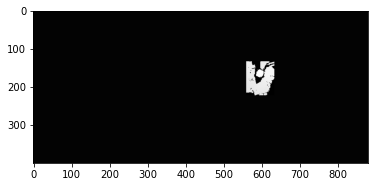

In [78]:
new_object=0
status=0
roilarge=[]
x = np.array([[0],[0]])
y = np.array([[0],[0]])
z = np.array([[0],[0]])
P_x = np.array([[1000, 0],[0, 1000]])
P_y = np.array([[1000, 0],[0, 1000]])
P_z = np.array([[1000, 0],[0, 1000]])
x_real = np.array([[0],[0]])
y_real = np.array([[0],[0]])
z_real = np.array([[0],[0]])
P_x_real = np.array([[1000, 0],[0, 1000]])
P_y_real = np.array([[1000, 0],[0, 1000]])
P_z_real = np.array([[1000, 0],[0, 1000]])
cx=0
cy=0
cz=00000.1
cx_right=0
cy_right=0
cz_right=0
memory_area=[[],[]]
memory=[[796],[796],[149],[149],[920],[920]]
center_coordinates=[0,0]
passed=0
memory_cnt=[0],[0],[0],[0]
memory_cnt_right=[0],[0],[0],[0]
new_index=0
medium=0
counter = 0
yhattt = []

#brown box range (100,250)
#black box range(300,450)
#book Mulitple View Geometry range(500,650) 
#book Robots range(650,800) 
#book Robots range(900,1100) 
#cup white range(1100,1250)
#cup red range(1300,1450)

for i in range(1080, 1130):
    
    
    gray1, gray2, gray1right, gray2right, img2, img2right= image(filename_left[i],filename_right[i],filename_left[i+1], filename_right[i+1])
    dis = disparitymap(gray1,gray1right)
    
    thresh=filtering(gray1, gray2, img2)
    thresh_right=filtering(gray1right, gray2right, img2right)
    index, cnts=biggest(thresh)
    index_right, cnts_right=biggest(thresh_right)
    
    
    area, status,new_object, cnt,detected,passed, new_index, medium = real(cnts, memory_area, new_object, index, status,passed, new_index, medium)
    area_right, status_right,new_object_right, cnt_right,detected_right,passed_right, new_index_right, medium_right = real(cnts_right, memory_area, new_object, index_right, status,passed, new_index, medium)

    
    #print("this is the status:", status)
    if new_object==1 or new_object==2:
        cx,cy,cz,circle, new_object,detected1, area1,roi, roilarge=show(area, img2, cnts, new_object,cx,cy,cz, index,memory_cnt)
    else:
        circle=img2.copy()
    if new_object_right==1 or new_object_right==2:
        cx_right,cy_right,cz_right,circle_right, new_object_right,detected1_right, area1_right,_, _=show(area_right, img2right, cnts_right, new_object_right,cx_right,cy_right,cz_right, index_right,memory_cnt_right)
    #error_x=center_coordinates[0]-cx
    #error_y=center_coordinates[1]-cy
    
    baseline = 120
    focallength = 2.60
    
    memory[0].append(cx)
    memory[1].append(x[0][0])
    
    memory[2].append(cy)
    memory[3].append(y[0][0])
    
    memory[4].append((baseline*focallength)/cz)
    memory[5].append((baseline*focallength)/z[0][0])
    
    cx_real,cy_real,cz_real=triangulation(cx,cx_right,cy,cy_right,cz,cz_right)
    
    #print(new_object)
    x,y,z,P_x,P_y,P_z, colour=kalman(cx,cy,cz,x,y,z,P_x,P_y,P_z, new_object,detected)
    
    x_real,y_real,z_real,P_x_real,P_y_real,P_z_real, colour=kalman(cx_real,cy_real,cz_real,x_real,y_real,z_real,P_x_real,P_y_real,P_z_real, new_object,detected)
    
    center_coordinates=(x[0][0],y[0][0])
    center_coordinates=(int(center_coordinates[0]),int(center_coordinates[1]))
    
    center_coordinates2=(x_real[0][0],y_real[0][0])
    center_coordinates2=(int(center_coordinates2[0]),int(center_coordinates2[1]))

    if new_object==1 or new_object==2:    
        final=cv2.circle(circle.copy(),center_coordinates,10,colour, cv2.FILLED)
        final2=cv2.circle(circle.copy(),center_coordinates2,10,colour, cv2.FILLED)
        
    else:
        final=circle.copy()
        final2=circle.copy()
    #cv2.imshow('yep',thresh)
    #plt.imshow(final)
    
    if (roilarge != [] and roilarge.shape[0] > 50 and roilarge.shape[1] > 50):
            classname, confidence,yhat = classifyImage(roilarge,model,yhattt)
            yhattt = yhat.copy()
            counter = counter + 1
            cv2.putText(final,"Class: %s, confidence: %.1f " % (classname,float(confidence)*100), (10,30), font, fontScale, fontColor, lineType)
            cv2.putText(final,"ROI shape %s " % (str(roi.shape)), (10,60), font, fontScale, fontColor, lineType)
            cv2.imshow('th', (cv2.cvtColor(roilarge, cv2.COLOR_RGB2GRAY)))
    cv2.imshow('final', final)
    cv2.imshow('final2', final2)
    cv2.waitKey(5)
    
cv2.destroyAllWindows()
cv2.waitKey(1)


In [74]:
decode_predictions(yhattt/counter, top = 1000)

[[('n04372370', 'switch', 0.08797075),
  ('n04040759', 'radiator', 0.07481152),
  ('n04254120', 'soap_dispenser', 0.072768144),
  ('n15075141', 'toilet_tissue', 0.0606639),
  ('n03131574', 'crib', 0.059638336),
  ('n03887697', 'paper_towel', 0.059082784),
  ('n03125729', 'cradle', 0.0326041),
  ('n03908714', 'pencil_sharpener', 0.029665755),
  ('n03916031', 'perfume', 0.021369036),
  ('n03314780', 'face_powder', 0.020540133),
  ('n04357314', 'sunscreen', 0.01990486),
  ('n02971356', 'carton', 0.018359233),
  ('n03690938', 'lotion', 0.017264396),
  ('n04380533', 'table_lamp', 0.015257032),
  ('n04070727', 'refrigerator', 0.014616141),
  ('n04344873', 'studio_couch', 0.013630209),
  ('n03637318', 'lampshade', 0.0132991765),
  ('n02786058', 'Band_Aid', 0.012073833),
  ('n04553703', 'washbasin', 0.009838703),
  ('n02948072', 'candle', 0.00980899),
  ('n03742115', 'medicine_chest', 0.008877918),
  ('n03937543', 'pill_bottle', 0.008721707),
  ('n04009552', 'projector', 0.0076166186),
  ('n04

In [51]:
decode_predictions(y, top = 1000)

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (2, 1)

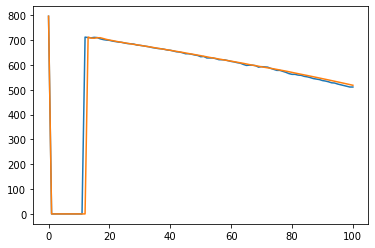

In [15]:
plt.plot(memory[0])
plt.plot(memory[1])

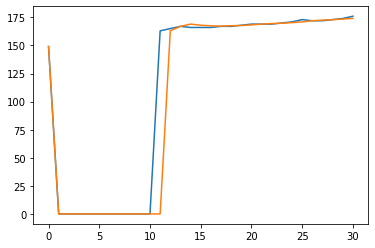

In [46]:
plt.plot(memory[2])
plt.plot(memory[3])

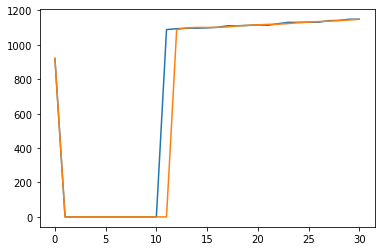

In [47]:
plt.plot(memory[4])
plt.plot(memory[5])